In [1]:
#Importing the all necessary modules, libraries, tools and models
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, r2_score
import warnings
warnings.filterwarnings('ignore')

# Step 1. Loading the data
try:
    energy_df = pd.read_csv('energy_dataset.csv.zip')
    weather_df = pd.read_csv('weather_features.csv.zip')
except FileNotFoundError:
    print("Error: One or both required CSV files not found. Please upload them to Colab.")
    exit()

# Step 2. Prepring the data and Merging them
energy_df['time'] = pd.to_datetime(energy_df['time'], utc=True)
energy_df = energy_df.set_index('time').sort_index()

weather_df['dt_iso'] = pd.to_datetime(weather_df['dt_iso'], utc=True)
weather_df = weather_df.set_index('dt_iso').sort_index()

WEATHER_COLS = ['temp', 'pressure', 'humidity', 'wind_speed', 'clouds_all', 'rain_1h']
weather_df_agg = weather_df.groupby(weather_df.index)[WEATHER_COLS].mean()

df = energy_df.merge(weather_df_agg, left_index=True, right_index=True, how='inner')


In [2]:
# Step 3. Data Cleaning (Final Strategy)
TARGET_COL = 'total load actual'

# 3.1. Filling all the missing values aggressively with interpolation
# It handles most NaNs in generation, price, and weather columns.
# if NAN wouldnt have handeled then a lot of data would have removed
# this was issue so filling those single empty block was better potion
df.interpolate(method='linear', inplace=True)

#Step 4. Feature Engineering

# 4.1. Time-Based Features
df['hour'] = df.index.hour
df['dayofweek'] = df.index.dayofweek
df['month'] = df.index.month
df['year'] = df.index.year
df['is_weekend'] = (df.index.dayofweek >= 5).astype(int)

# 4.2. Lagged Load Features (Creates 168 NaNs at the start)
df['Load_Lag_24'] = df[TARGET_COL].shift(24)
df['Load_Lag_168'] = df[TARGET_COL].shift(168)

# 4.3. Non-linear Weather Features
df['temp_celsius'] = df['temp'] - 273.15
df['Temp_Squared'] = df['temp_celsius'] ** 2
df['Temp_Dev_20'] = abs(df['temp_celsius'] - 20)

# 4.4 FINAL SAFE CLEANUP: Droping ONLY the rows where the TARGET or
# the essential Lagged Feature is missing. This prevents the test set from being emptied.
df.dropna(subset=[TARGET_COL, 'Load_Lag_168'], inplace=True)

In [3]:
# Step 5. Data Splitting (Time-Series Spliting)
test_size = 0.10
split_point = int(len(df) * (1 - test_size))

train_df = df.iloc[:split_point].copy()
test_df = df.iloc[split_point:].copy()

# Printing the sizes (for checking purposes)
print(f"Train DF size: {len(train_df)} samples")
print(f"Test DF size: {len(test_df)} samples")

EXCLUDE_COLS = [TARGET_COL, 'temp']
FEATURES = [col for col in train_df.columns if col not in EXCLUDE_COLS]

X_train = train_df[FEATURES]
y_train = train_df[TARGET_COL]

X_test = test_df[FEATURES]
y_test = test_df[TARGET_COL]

# Step 6. XGBoost Model Training and Evaluation step
print("Starting XGBoost Training...")

# training for a less or fixed number of trees.
xgb_reg = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=500, # Reduceding estimators for faster training without early stopping
    learning_rate=0.05, # Adjusteding the learning rate
    max_depth=7,
    subsample=0.7,
    colsample_bytree=0.7,
    random_state=42,
    n_jobs=-1
)

# Training using only essential arguments
xgb_reg.fit(
    X_train,
    y_train,
    verbose=True # Set to True to see training progress for each tree
)

# Predictions step
y_pred_xgb = xgb_reg.predict(X_test)

# Evaluation step
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)

print("\n" + "="*60)
print("✅ XGBoost Training Complete.")
print(f"   Model trained on {xgb_reg.n_estimators} trees.")
print(f"   Test Set Size: {len(y_test)} hours")
print("="*60)
print(f"Random Forest (Previous Result): R^2 = 0.3848")
print("-" * 60)
print(f"⭐ XGBoost MAE (Mean Absolute Error): {mae_xgb:,.2f} Mw")
print(f"⭐ XGBoost R^2 Score: {r2_xgb:.4f}")
print("="*60)

Train DF size: 31406 samples
Test DF size: 3490 samples
Starting XGBoost Training...

✅ XGBoost Training Complete.
   Model trained on 500 trees.
   Test Set Size: 3490 hours
Random Forest (Previous Result): R^2 = 0.3848
------------------------------------------------------------
⭐ XGBoost MAE (Mean Absolute Error): 317.86 Mw
⭐ XGBoost R^2 Score: 0.9917


I am adding the below code just for the evaluation and visual representation of code although it is not a main part or step in model

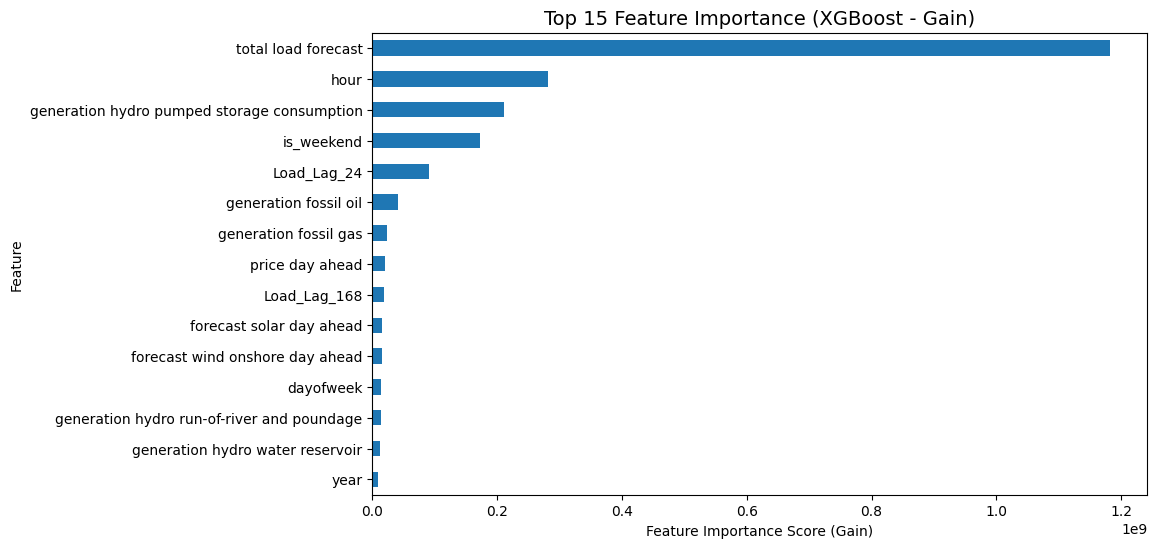


🥇 The Top 5 Most Important Features are:
1. total load forecast: 1182628864.00
2. hour: 281070464.00
3. generation hydro pumped storage consumption: 211480672.00
4. is_weekend: 172662496.00
5. Load_Lag_24: 90946208.00


Final Model R^2 Score: 0.9917


In [4]:
import matplotlib.pyplot as plt

# 1. Extracting Feature Importance
# XGBoost provides 'gain' importance, which is the relative contribution of each feature
# to the model's prediction accuracy.
importance = xgb_reg.get_booster().get_score(importance_type='gain')

# Convertin the importance scores to a pandas Series for easy sorting and plotting
feature_importance = pd.Series(importance).sort_values(ascending=False)

# 2. Plotting the Top Features

# Selecting the top 15 features to plot for clarity
TOP_N = 15
plot_data = feature_importance.head(TOP_N)

plt.figure(figsize=(10, 6))
plot_data.plot(kind='barh')
plt.title(f'Top {TOP_N} Feature Importance (XGBoost - Gain)', fontsize=14)
plt.xlabel('Feature Importance Score (Gain)')
plt.ylabel('Feature')
plt.gca().invert_yaxis() # Displaying the most important feature at the top
plt.show()

# 3. Interpretation
print("\n" + "="*50)
print(f"🥇 The Top 5 Most Important Features are:")
print("="*50)
for i, (feature, score) in enumerate(plot_data.head(5).items()):
    print(f"{i+1}. {feature}: {score:.2f}")

print("\n")
# Printing the R2 score again for context
print(f"Final Model R^2 Score: {r2_xgb:.4f}")
print("="*50)